<a href="https://colab.research.google.com/github/pmajgawali/Self-Driving/blob/branch1/sun2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/pmajgawali/Track

Cloning into 'Track'...
remote: Enumerating objects: 22391, done.
remote: Total 22391 (delta 0), reused 0 (delta 0), pack-reused 22391
Receiving objects: 100% (22391/22391), 334.52 MiB | 36.12 MiB/s, done.
Checking out files: 100% (22387/22387), done.


Importing necessary libraries

In [3]:
!pip3 install imgaug

In [4]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
import cv2
import pandas as pd
from imgaug import augmenters as iaa
import random
import ntpath
import matplotlib.image as mpimg
from google.colab import files

Using TensorFlow backend.


Importing the training data

In [5]:
datadir = 'Track/NewData'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  P:\Self Driving\NewData\IMG\center_2020_03_15_10_14_37_719.jpg  ...  30.19028
1  P:\Self Driving\NewData\IMG\center_2020_03_15_10_14_37_778.jpg  ...  30.19030
2  P:\Self Driving\NewData\IMG\center_2020_03_15_10_14_37_867.jpg  ...  30.19029
3  P:\Self Driving\NewData\IMG\center_2020_03_15_10_14_37_952.jpg  ...  30.19030
4  P:\Self Driving\NewData\IMG\center_2020_03_15_10_14_38_035.jpg  ...  30.19029

[5 rows x 7 columns]

Removing redundant file paths

In [6]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2020_03_15_10_14_37_719.jpg  ...  30.19028
1  center_2020_03_15_10_14_37_778.jpg  ...  30.19030
2  center_2020_03_15_10_14_37_867.jpg  ...  30.19029
3  center_2020_03_15_10_14_37_952.jpg  ...  30.19030
4  center_2020_03_15_10_14_38_035.jpg  ...  30.19029

[5 rows x 7 columns]

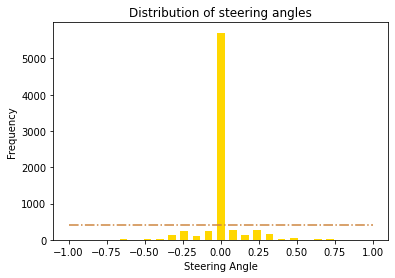

In [8]:
num_bins = 25
hist,bins = np.histogram(data['steering'],bins=num_bins)
center = (bins[1:] + bins[:-1])*0.5
plt.bar(center,hist,width=0.05,color='gold')
plt.title('Distribution of steering angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')

thresh = 400
plt.plot([np.min(data['steering']),np.max(data['steering'])],[thresh,thresh],linestyle='-.',color='peru')

plt.savefig('Distribution of steering angles.png')
files.download('Distribution of steering angles.png')

To prevent the distribution from getting biased , the car was driven around the track in clockwise as well as anti-clockwise direction

However,the frequency of 0 is more than that of non zero values.Using this as the training data will cause the model to be biased towards a zero steering angle.This will degrade the performance at sharp turns.

Therefore we set a threshold for maximum frequency.

In [0]:
def bin_finder(value,bins):
  # ith bin holds values between (bins[i-1] , bins[i]]
  L = 1
  R = len(bins)-1
  while (L < R):
    mid = (L + R)//2
    if (bins[mid] == value):
      return mid
    elif (bins[mid] < value):
      L = mid+1
    else:
      R = mid
  
  return L

0.0


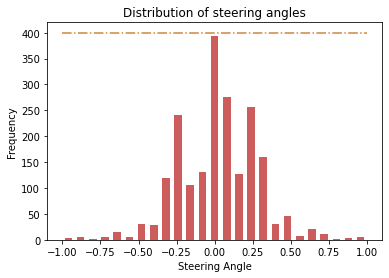

In [10]:
#identify the members which belong to a certain bin

bin_members = [list() for i in range(len(center))]
for idx in range(len(data['steering'])):
  val = data['steering'][idx]
  bin_members[bin_finder(val,center)].append(idx)

to_remove = []
random.seed(1)

#if the size of the bin is greater than the threshold,shuffle the members of that bin and arbitrarily delete some data
for bin_idx in range(len(center)):
  if (len(bin_members[bin_idx]) > thresh):
    #bin_members[bin_idx] = 
    print(center[bin_idx])
    random.shuffle(bin_members[bin_idx])
    to_remove.extend(bin_members[bin_idx][thresh:])

data.drop(data.index[to_remove],inplace=True)

hist,_ = np.histogram(data['steering'],bins=num_bins)
plt.bar(center,hist,width=0.05,color='indianred')
plt.title('Distribution of steering angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')

plt.plot([np.min(data['steering']),np.max(data['steering'])],[thresh,thresh],linestyle='-.',color='peru')

plt.savefig('Distribution of steering angles_threshold_cutoff.png')
files.download('Distribution of steering angles_threshold_cutoff.png')

In [0]:
def load_img_steering(datadir,df):
  '''Returns two lists a and b such that for center image at a[i] the corresponding steering angle is b[i]'''
  image_path = []
  steering = []
  for i in range(len(data)):
    idx_data = data.iloc[i]
    center,left,right = idx_data[0],idx_data[1],idx_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(idx_data[3]))
  
  return np.array(image_path),np.array(steering)

image_path,steering = load_img_steering(datadir+"/IMG",data)

Splitting data into training and validation sets

In [12]:
X_train,X_valid,y_train,y_valid = train_test_split(image_path,steering,test_size=0.2,random_state=5)

print("Training:" + str(len(X_train)))
print("Validation:" + str(len(X_valid)))

Training:1629
Validation:408


Distribution of steering angles in the training and validation sets

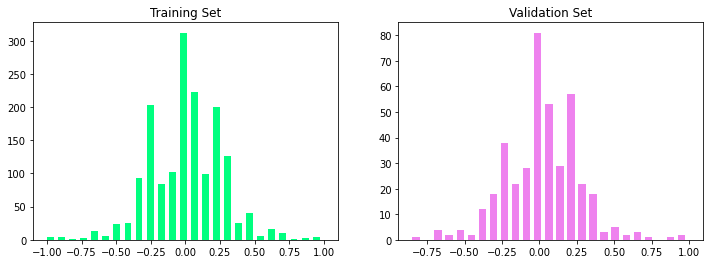

In [13]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='springgreen')
axes[0].set_title('Training Set')

axes[1].hist(y_valid,bins=num_bins,width=0.05,color='violet')
axes[1].set_title('Validation Set')

plt.savefig('Distribution of steering angles_train_val.png')
files.download('Distribution of steering angles_train_val.png')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

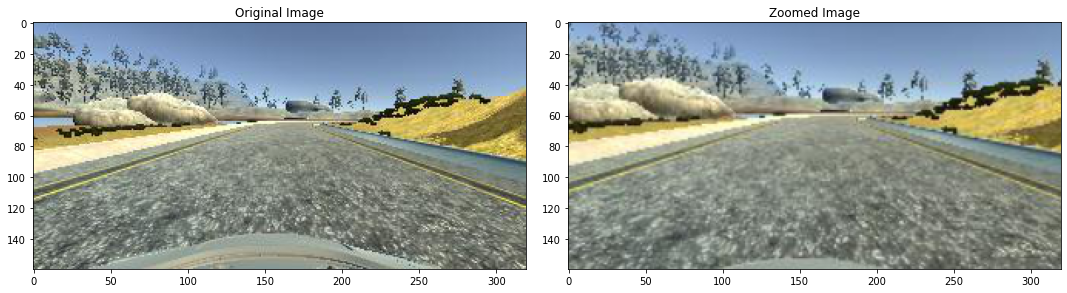

In [15]:
test_image = mpimg.imread(image_path[random.randint(0,len(image_path)-1)])
zoomed_image = zoom(test_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(test_image)
axes[0].set_title('Original Image')

axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')


In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

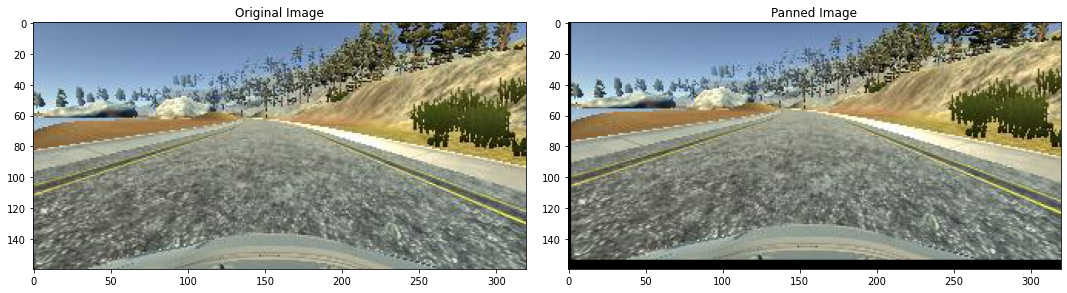

In [17]:
test_image = mpimg.imread(image_path[random.randint(0,len(image_path)-1)])
panned_image = pan(test_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(test_image)
axes[0].set_title('Original Image')

axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

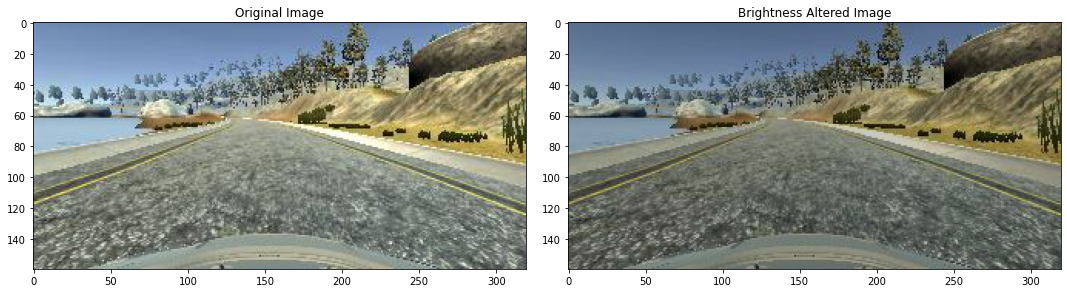

In [19]:
test_image = mpimg.imread(image_path[random.randint(0,len(image_path)-1)])
brightness_altered_image = img_random_brightness(test_image)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(test_image)
axes[0].set_title('Original Image')

axes[1].imshow(brightness_altered_image)
axes[1].set_title('Brightness Altered Image')

In [0]:
def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image,steering_angle

Text(0.5, 1.0, 'Flipped Image Steering angle:-0.0')

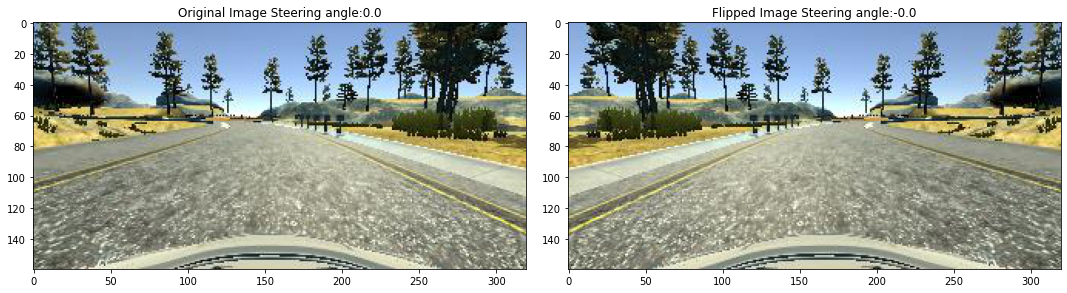

In [21]:
random_idx = random.randint(0,len(image_path)-1)
steering_angle = steering[random_idx]
test_image = mpimg.imread(image_path[random_idx])

flipped_image,flipped_steering_angle = img_random_flip(test_image,steering_angle)

fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(test_image)
axes[0].set_title('Original Image Steering angle:'+str(steering_angle))

axes[1].imshow(flipped_image)
axes[1].set_title('Flipped Image Steering angle:'+str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  if (np.random.rand() > 0.5):
    image = zoom(image)
  if (np.random.rand() > 0.5):
    image = pan(image)
  if (np.random.rand() > 0.5):
    image = img_random_brightness(image)
  if (np.random.rand() > 0.5):
    image,steering_angle = img_random_flip(image,steering_angle)
  
  return image,steering_angle

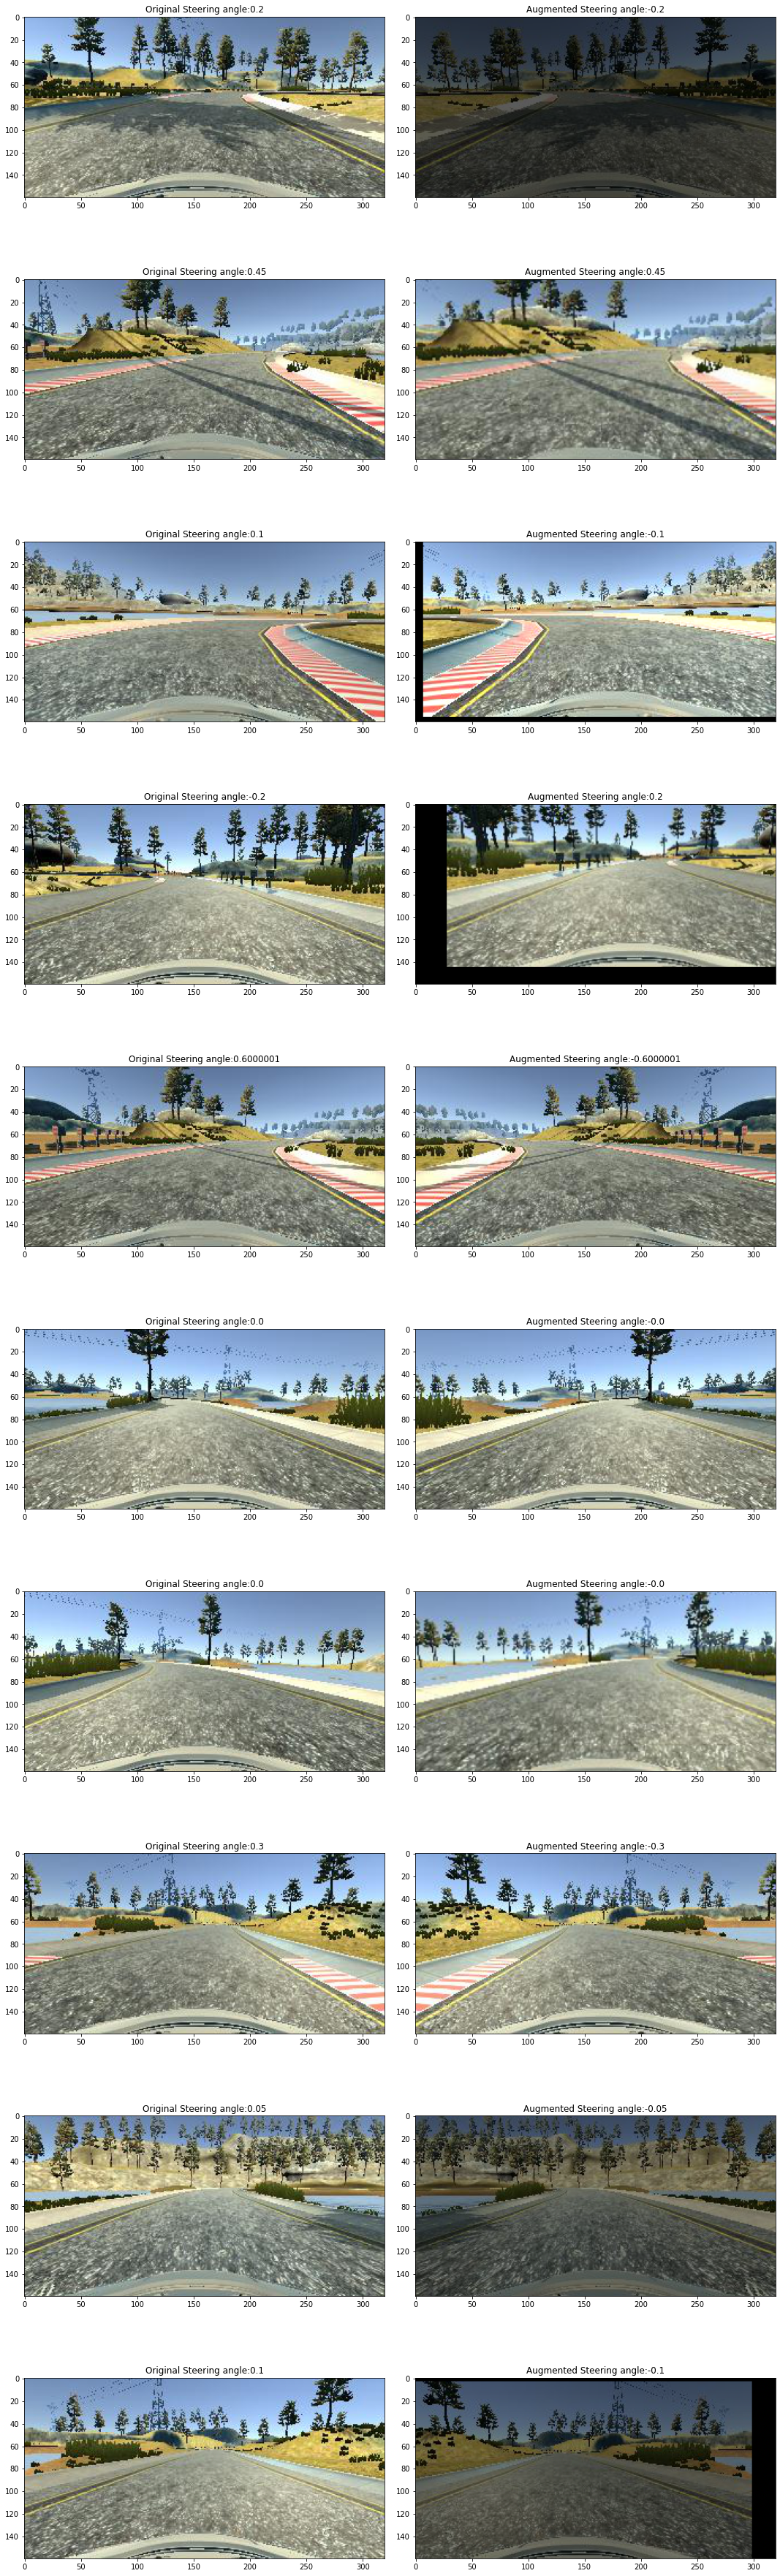

In [23]:
n_col = 2
n_row = 10

fig,axes = plt.subplots(n_row,n_col,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  idx = random.randint(0,len(image_path)-1)
  image = mpimg.imread(image_path[idx])
  original_steering_angle = steering[idx]

  axes[i][0].imshow(image)
  axes[i][0].set_title('Original Steering angle:'+str(original_steering_angle))

  augmented_image,new_steering_angle = random_augment(image,original_steering_angle)

  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title('Augmented Steering angle:'+str(new_steering_angle))

Preprocessing the Images

In [0]:
def preprocess_img(img_path):
  image = mpimg.imread(img_path)
  image = image[60:135,:,:]
  image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
  image = cv2.GaussianBlur(image,(3,3),0)
  image = cv2.resize(image,(200,66))
  image = image/255
  return image

Demonstration on a random image

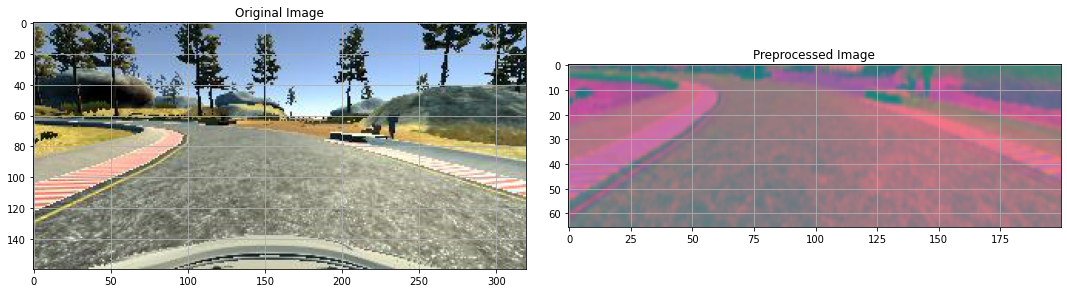

In [25]:
img_path = image_path[150]
original = mpimg.imread(img_path)
preprocessed = preprocess_img(img_path)

fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.tight_layout()
axes[0].imshow(original)
axes[0].set_title('Original Image')
axes[0].grid('on')
axes[1].imshow(preprocessed)
axes[1].set_title('Preprocessed Image')
axes[1].grid('on')

In [0]:
X_train = np.array(list(map(preprocess_img,X_train)))
X_valid = np.array(list(map(preprocess_img,X_valid)))

Verifying preprocessing on a random sample

(66, 200, 3)


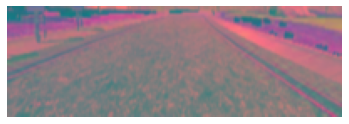

In [27]:
plt.imshow(X_train[250])
plt.axis('off')
print(X_train[250].shape)

End of preprocessing

---



Defining the model

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),input_shape=X_train[0].shape,activation='elu',strides=(2,2)))
  model.add(Convolution2D(36,(5,5),activation='elu',strides=(2,2)))
  model.add(Convolution2D(48,(5,5),activation='elu',strides=(2,2)))
  model.add(Convolution2D(64,(3,3),activation='elu'))
  model.add(Convolution2D(64,(3,3),activation='elu'))

  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100,activation='elu'))

  model.add(Dropout(0.5))

  model.add(Dense(50,activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1,activation='elu'))

  optimizer = Adam(lr=0.001)
  model.compile(loss='mse',optimizer=optimizer)

  return model

In [29]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [30]:
history = model.fit(X_train,y_train,epochs=35,validation_data=(X_valid,y_valid),batch_size=100,shuffle=1,verbose=1)

Train on 1629 samples, validate on 408 samples
Epoch 1/35
1629/1629 [==============================] - 8s 5ms/step - loss: 0.5801 - val_loss: 0.3778
Epoch 2/35
1629/1629 [==============================] - 1s 327us/step - loss: 0.2204 - val_loss: 0.0633
Epoch 3/35
1629/1629 [==============================] - 1s 321us/step - loss: 0.0973 - val_loss: 0.0572
Epoch 4/35
1629/1629 [==============================] - 1s 328us/step - loss: 0.0831 - val_loss: 0.0565
Epoch 5/35
1629/1629 [==============================] - 1s 325us/step - loss: 0.0762 - val_loss: 0.0539
Epoch 6/35
1629/1629 [==============================] - 1s 330us/step - loss: 0.0706 - val_loss: 0.0508
Epoch 7/35
1629/1629 [==============================] - 1s 333us/step - loss: 0.0688 - val_loss: 0.0473
Epoch 8/35
1629/1629 [==============================] - 1s 336us/step - loss: 0.0623 - val_loss: 0.0480
Epoch 9/35
1629/1629 [==============================] - 1s 330us/step - loss: 0.0624 - val_loss: 0.0431
Epoch 10/35
1629/16

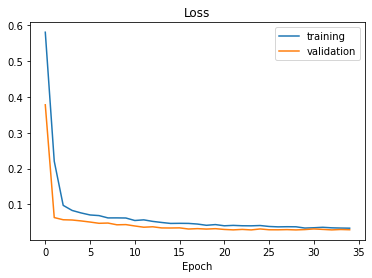

In [32]:
fig,axes = plt.subplots(1,1)
axes.plot(history.history['loss'])
axes.plot(history.history['val_loss'])
axes.legend(['training','validation'])
axes.set_title('Loss')
axes.set_xlabel('Epoch')

plt.savefig('Training_validation_loss.png')
files.download('Training_validation_loss.png')

In [0]:
model.save('model.h5')

In [0]:
files.download('model.h5')